<a href="https://colab.research.google.com/github/SkovenForrest/Cellari_project/blob/Mask_RCNN/RCNN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load data

In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
import glob
import natsort
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#drive.mount("/content/drive", force_remount=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!ls drive/'My Drive'
!ls drive/'My Drive/Cellari_project/Gland_dataset' &> /dev/null

images_path = 'drive/My Drive/Cellari_project/Gland_dataset/*'

In [4]:
images = []
masks = []

# image preperation
train_images = glob.glob(images_path)
sorted_train_images = natsort.natsorted(train_images, reverse=False)


In [5]:
for img in train_images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[-1]
    if imagg == "anno":
        masks.append(img)
    else:
        images.append(img)

print(len(images))
print(len(masks))
#print(imagg)


145
145


In [6]:
train_orig_images = []
train_masks = []

test_orig_images = []
test_masks = []

In [7]:
for img in images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_orig_images.append(img)
    else:
        train_orig_images.append(img)

for mask in masks:
    mask_img = mask.split("/")[-1].split(".")[0]
    imagg = mask_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_masks.append(mask)
    else:
        train_masks.append(mask)


In [8]:
print(len(train_orig_images), len(train_masks))
print(len(test_orig_images), len(test_masks))

85 85
60 60


In [9]:
sorted_train_images = natsort.natsorted(train_orig_images, reverse=False)
sorted_train_masks = natsort.natsorted(train_masks, reverse=False)

sorted_test_images = natsort.natsorted(test_orig_images, reverse=False)
sorted_test_masks = natsort.natsorted(test_masks, reverse=False)

In [10]:
#mean = (0.485, 0.456, 0.406)
#std = (0.229, 0.224, 0.225)
#mean = np.array([0.5, 0.5, 0.5])
#std = np.array([0.5, 0.5, 0.5])
mean = np.array([0.7874, 0.5112, 0.7851])
std = np.array([0.1522, 0.2089, 0.111])

transformations = transforms.Compose([transforms.Resize((512,512)) , transforms.ToTensor() , transforms.Normalize(mean, std)])



In [11]:
"""
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
img = Image.open(sorted_test_images[55]).convert("RGB")
img = img.resize((512,512))
plt.imshow(img)
"""
"""
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
img = []
for i in range(0,60):
  img.append(Image.open(sorted_test_images[i]).convert("RGB"))
#img = img.resize((512,512))
#plt.imshow(img)
"""

'\nfrom PIL import Image\nimport matplotlib.pyplot as plt\nfrom skimage.transform import resize\nimg = []\nfor i in range(0,60):\n  img.append(Image.open(sorted_test_images[i]).convert("RGB"))\n#img = img.resize((512,512))\n#plt.imshow(img)\n'

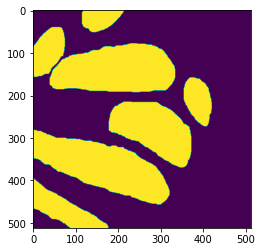

In [12]:
#check mask
mask = Image.open(sorted_train_masks[61])
mask = mask.resize((512,512))
mask = np.array(mask)
for x in range(0,mask.shape[0]):
          for y in range(0, mask.shape[1]):
            if mask[x,y] >0:
              mask[x,y] = 255
plt.imshow(mask)

In [13]:
"""
for x in range(0,mask.shape[0]):
    for y in range(0, mask.shape[1]):
        if mask[x,y] == 6:
          print("coordinate", {x,y})
"""

'\nfor x in range(0,mask.shape[0]):\n    for y in range(0, mask.shape[1]):\n        if mask[x,y] == 6:\n          print("coordinate", {x,y})\n'

In [14]:
import os
import numpy as np
import torch
from PIL import Image


class CellarDataset(object):
    def __init__(self, images, masks, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = images
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, idx):
        #print("current idx =",idx)
        #print("len self.imgs =",len(self.imgs))
        img = Image.open(self.imgs[idx]).convert("RGB")
        #img = img.resize((512,512))
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(self.masks[idx])
        #mask = mask.resize((512,512))
        
        mask = np.array(mask)
        #convert to black and white image
        """
        for x in range(0,mask.shape[0]):
          for y in range(0, mask.shape[1]):
            if mask[x,y] >0:
              mask[x,y] = 255
        """
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmax-xmin > 2 and ymax-ymin > 2 :
              boxes.append([xmin, ymin, xmax, ymax])
            else :
              obj_ids = np.delete(obj_ids,i)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #target["area"] = 1 
        #target["iscrowd"] = False 
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

#Modifying the model from a pretrained RCNN

In [15]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)
#roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                #output_size=7,
                                                #sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)



In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [17]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [18]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [19]:
# use our dataset and defined transformations
dataset = CellarDataset(sorted_train_images,sorted_train_masks,get_transform(train=True))
dataset_test = CellarDataset(sorted_test_images,sorted_test_masks,get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices_train = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
#dataset = torch.utils.data.Subset(dataset, indices_train[:])
#dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:])
dataset = torch.utils.data.Subset(dataset, indices_train[:])
dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


print(indices_train)
print(len(dataset))

[70, 60, 72, 5, 83, 78, 33, 48, 8, 9, 6, 44, 3, 84, 26, 55, 37, 74, 14, 71, 25, 58, 75, 39, 68, 61, 18, 57, 66, 4, 21, 69, 32, 11, 29, 30, 40, 67, 22, 43, 15, 82, 51, 54, 63, 50, 0, 46, 81, 53, 79, 2, 56, 77, 59, 24, 76, 23, 20, 35, 7, 36, 65, 62, 73, 12, 28, 42, 10, 49, 17, 27, 13, 38, 80, 34, 19, 47, 64, 52, 1, 31, 16, 41, 45]
85


#Training


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
                            
#optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 30

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/17]  eta: 0:01:02  lr: 0.000317  loss: 7.4057 (7.4057)  loss_classifier: 0.5218 (0.5218)  loss_box_reg: 0.5583 (0.5583)  loss_mask: 5.6256 (5.6256)  loss_objectness: 0.6221 (0.6221)  loss_rpn_box_reg: 0.0780 (0.0780)  time: 3.7050  data: 1.9384  max mem: 5531
Epoch: [0]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 2.0343 (2.7204)  loss_classifier: 0.4140 (0.4169)  loss_box_reg: 0.5583 (0.5539)  loss_mask: 0.7705 (1.4563)  loss_objectness: 0.1337 (0.2167)  loss_rpn_box_reg: 0.0750 (0.0765)  time: 1.6250  data: 0.1312  max mem: 6233
Epoch: [0] Total time: 0:00:27 (1.6313 s / it)
creating index...
index created!
Test:  [ 0/60]  eta: 0:00:51  model_time: 0.3856 (0.3856)  evaluator_time: 0.1788 (0.1788)  time: 0.8597  data: 0.2894  max mem: 6233
Test:  [59/60]  eta: 0:00:00  model_time: 0.2427 (0.2467)  evaluator_time: 0.1531 (0.1581)  time: 0.4176  data: 0.0042  max mem: 6233
Test: Total time: 0:00:25 (0.4207 s / it)
Averaged stats: model_time: 0.2427 (0.2467)  evaluator_tim

In [ ]:
"""
!git clone https://github.com/scikit-image/scikit-image.git
!cd scikit-image
!pip install -e
"""

In [ ]:
from skimage.measure import label
from skimage import metrics
import skimage
"""
os.chdir('/content/scikit-image/skimage/metrics')
from set_metrics import hausdorff_distance
#from skimage.metrics import hausdorff_distance
os.chdir('/content/drive/My Drive/Cellari_project/Gland_dataset')
#!ls drive/'My Drive/Cellari_project/Gland_dataset' &> /dev/null
"""

# Metrics


In [ ]:
import numpy as np
from scipy.spatial import cKDTree

def hausdorff_distance(image0, image1):
    a_points = np.transpose(np.nonzero(image0))
    b_points = np.transpose(np.nonzero(image1))
    if len(a_points) == 0:
        return 0 if len(b_points) == 0 else np.inf
    elif len(b_points) == 0:
        return np.inf

    return max(max(cKDTree(a_points).query(b_points, k=1)[0]),
               max(cKDTree(b_points).query(a_points, k=1)[0]))

In [ ]:
import numpy as np
from skimage.measure import label


class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=si, y_pred=gi)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_p = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_p == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_p)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_p)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true =np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred =(roi_y_pred==matching_idx)*1

        if y_true_p_switch:
            return roi_y_true, roi_y_pred
        else:
            return roi_y_pred, roi_y_true

    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y
        

#score

In [ ]:
#check mask
mask = Image.open(sorted_test_images[51])
mask = mask.resize((512,512))
mask = np.array(mask)
plt.imshow(mask)

In [ ]:
#os.chdir('/content/drive')
#dataset_test[4]


In [ ]:
img, features = dataset_test[0]
  # put the model in evaluation mode
model.eval()
with torch.no_grad():
      prediction = model([img.to(device)])
prediction[0]['scores']

In [ ]:
count = 0
f1 = 0
f1_obj = 0
iou = 0
iou_obj = 0
hausdorff_obj_distance = 0

for j in range(0,len(dataset_test)):
  if j%10 == 0:
    print("Done with prediction number",j)
  # pick one image from the test set
  img, features = dataset_test[j]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  # create the true mask of the image
  masks = features['masks']
  mask_np = masks.mul(255).permute(1, 2, 0).byte().cpu().numpy()
  for i in range(0,mask_np.shape[2]):
    mask = mask_np[:,:,i]
    if i != 0:
      true_mask = np.bitwise_or(true_mask,mask)
    else:
      true_mask = mask

  #create the predicted mask of the image
  img_np = prediction[0]['masks'][:, 0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
  scores = prediction[0]['scores']
  for k in range(0,img_np.shape[2]):
    if scores[k] > 0.5:
      img = img_np[:,:,k]
      if k != 0:
        predicted_cells = np.bitwise_or(predicted_cells,img)
      else:
        predicted_cells = mask
    
  # score the pridiction
  metrics = BinaryImageMetrics(true_mask, predicted_cells)
  count += metrics.get_count()
  f1 += metrics.get_f1()
  f1_obj += metrics.get_f1_obj()
  iou += metrics.get_iou()
  iou_obj += metrics.get_iou_obj()
  hausdorff_obj_distance += metrics.get_hausdorff_obj_distance()


count_avg = count/len(dataset_test)
f1_avg = f1/len(dataset_test)
f1_obj_avg = f1_obj/len(dataset_test)
iou_avg = iou/len(dataset_test)
iou_obj_avg = iou_obj/len(dataset_test)
hausdorff_obj_distance_avg = hausdorff_obj_distance/len(dataset_test)

print(f"Count ratio is: {count_avg}")
print(f"F1 score is : {f1_avg}")
print(f"F1 object score is: {f1_obj_avg}")
print(f"IoU score is : {iou_avg}")
print(f"IoU object score is : {iou_obj_avg}")
print(f"Hausdroff object distance score is : {hausdorff_obj_distance_avg}")



In [ ]:
  metrics = BinaryImageMetrics(true_mask, predicted_cells)
  count = metrics.get_count()
  print(f"Count ratio is: {count}")
  f1 = metrics.get_f1()
  print(f"F1 score is : {f1}")
  f1_obj = metrics.get_f1_obj()
  print(f"F1 object score is: {f1_obj}")
  iou = metrics.get_iou()
  print(f"IoU score is : {iou}")
  iou_obj = metrics.get_iou_obj()
  print(f"IoU object score is : {iou_obj}")
  hausdorff_obj_distance = metrics.get_hausdorff_obj_distance()
  print(f"Hausdroff object distance score is : {hausdorff_obj_distance}")

In [ ]:
  #plt.imshow(true_mask,cmap='gray')
  #plt.show()

In [ ]:
# plt.imshow(predicted_cells,cmap='gray')
#  plt.show()

In [ ]:
#prediction

In [ ]:
"""
img_np = prediction[0]['masks'][:, 0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
print(img_np.shape)
predicted_cells = None
for i in range(0,img_np.shape[2]):
  img = img_np[:,:,i]
  if i != 0:
    predicted_cells = np.bitwise_or(predicted_cells,img)
  else:
    predicted_cells = mask

plt.imshow(predicted_cells,cmap='gray')
plt.show()
"""

In [ ]:
#draw contours

img, features = dataset_test[0]
  # put the model in evaluation mode
model.eval()
with torch.no_grad():
      prediction = model([img.to(device)])
masks = features['masks']
true_mask = None
mask_np = masks.mul(255).permute(1, 2, 0).byte().cpu().numpy() 
for i in range(0,mask_np.shape[2]):
    mask = mask_np[:,:,i]
    if i != 0:
      true_mask = np.bitwise_or(true_mask,mask)
    else:
      true_mask = mask
img = img.mul(255).permute(1, 2, 0).byte().numpy()
scores = prediction[0]['scores']
    
for i in range(len(prediction[0]['masks'])):
    # iterate over masks
    if scores[k] > 0.5:
      mask = prediction[0]['masks'][i, 0]
      mask = mask.mul(255).byte().cpu().numpy()
      contours, _ = cv2.findContours(
              mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
      cv2.drawContours(img, contours, -1, (0, 0, 255), 20, cv2.LINE_AA)
      cv2.drawContours(true_mask, contours, -1, (0, 0, 255), 20, cv2.LINE_AA)

#cv2.imshow('img output', img_cv)
plt.imshow(img)
plt.show()

In [ ]:
plt.imshow(true_mask)
plt.show()

In [ ]:


plt.imshow(predicted_cells)
plt.show()